White River sims: 350
Iowa River sims:  350

White files: ['H10', 'H100', 'H102', 'H103', 'H104']...
Iowa files:  ['H100iw', 'H101iw', 'H102iw', 'H104iw', 'H105iw']...

Loading White River: H10.pt
  Timesteps: 48
Loading Iowa River: H100iw.pt
  Timesteps: 21

MESH ANALYSIS: White River (H10)
Nodes: 4,787
Edges: 19,148 (directed)  |  9,574 (undirected)
Avg degree: 4.00

--- Neighbor Count Distribution ---
 Neighbors    Count  Percent Cumulative
----------------------------------------
         4     4787   100.0%     100.0%

--- 2-hop Extension Impact at Various Thresholds ---
  min_neighbors=4:      0 nodes (0.0%) would be extended
  min_neighbors=5:   4787 nodes (100.0%) would be extended
  min_neighbors=6:   4787 nodes (100.0%) would be extended
  min_neighbors=7:   4787 nodes (100.0%) would be extended
  min_neighbors=8:   4787 nodes (100.0%) would be extended

--- Edge Lengths ---
  Min: 0.002264  Max: 0.017544
  Mean: 0.011094  Median: 0.010196
  Max/Min ratio: 7.8

--- Spatial Ex

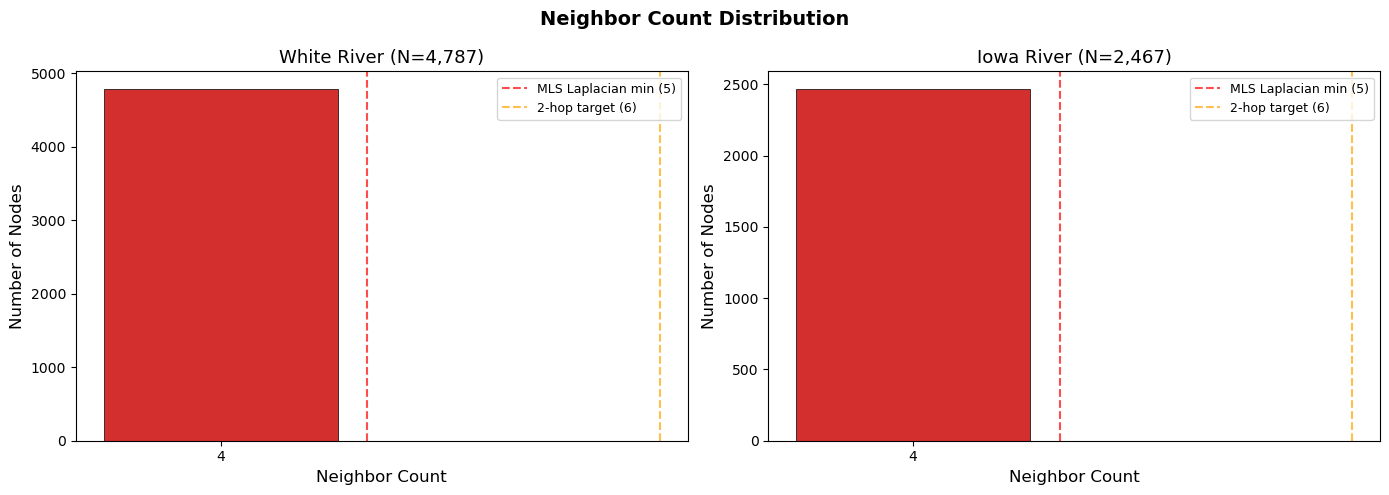

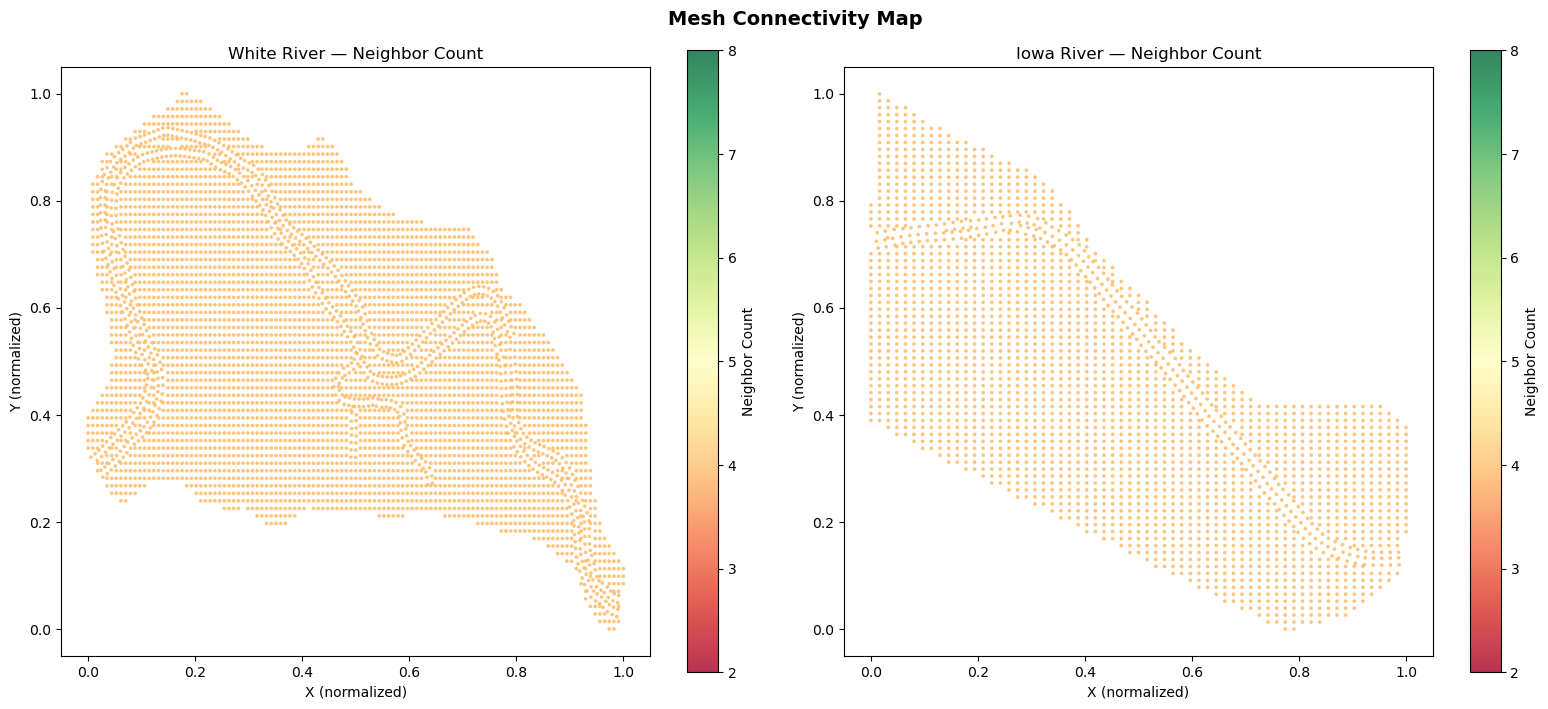

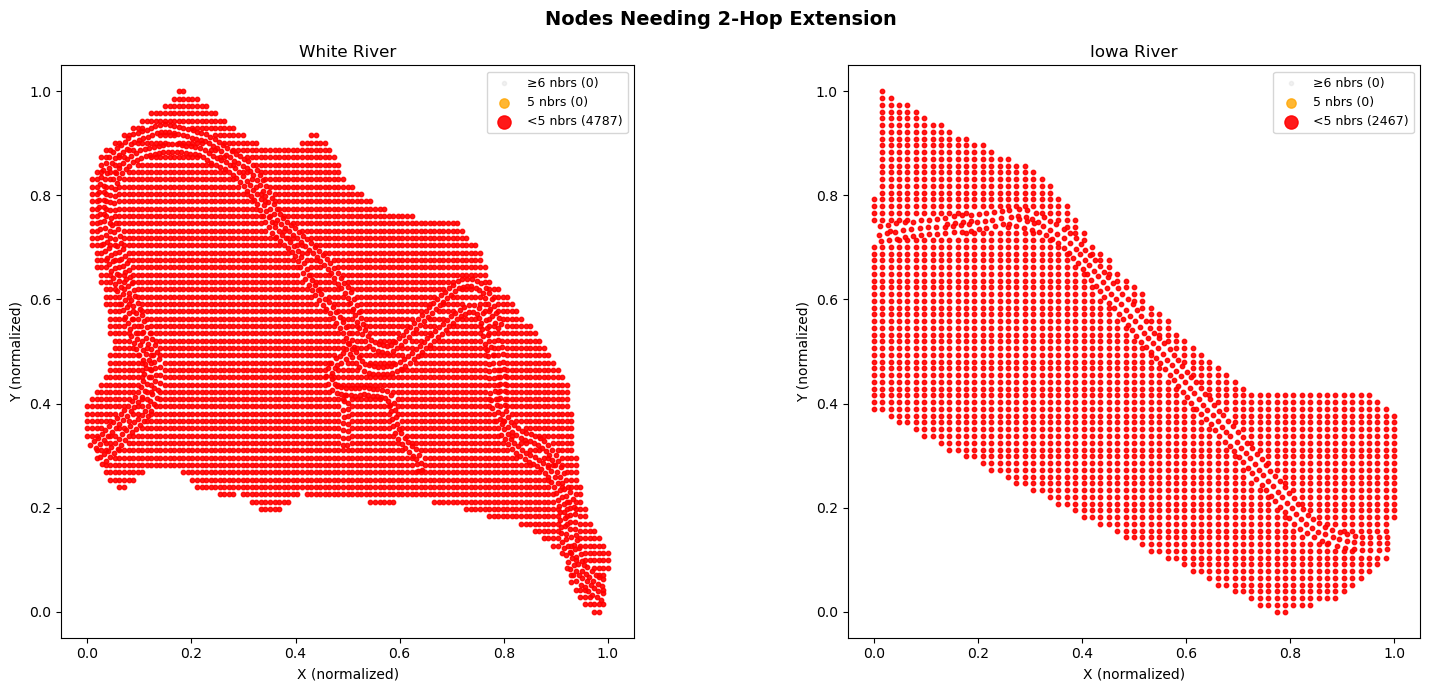

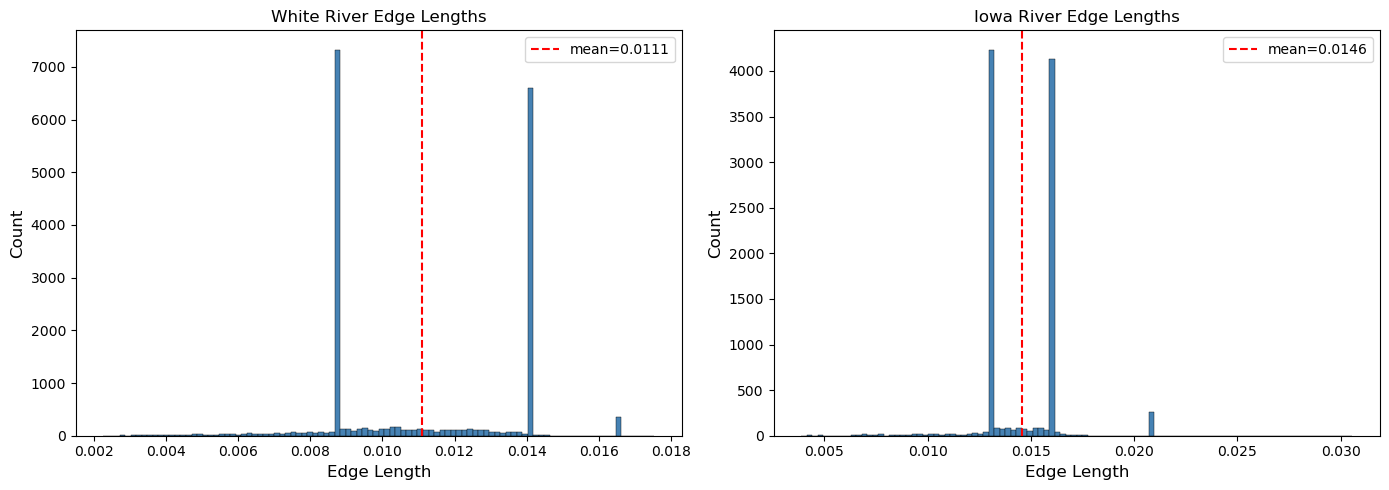

SUMMARY & RECOMMENDATION

White River (N=4,787):
  Nodes <5 neighbors:   4787 (100.0%)
  Nodes <6 neighbors:   4787 (100.0%)
  → MAJORITY have <6 neighbors — structured/quad mesh
  → 2-hop (min=6) extends 100% of nodes = too aggressive
  → RECOMMENDATION: try min_2hop_neighbors=5 or disable 2-hop

Iowa River (N=2,467):
  Nodes <5 neighbors:   2467 (100.0%)
  Nodes <6 neighbors:   2467 (100.0%)
  → MAJORITY have <6 neighbors — structured/quad mesh
  → 2-hop (min=6) extends 100% of nodes = too aggressive
  → RECOMMENDATION: try min_2hop_neighbors=5 or disable 2-hop


In [2]:
"""
River Mesh Diagnostic — Jupyter Notebook Version
=================================================
Copy each section (marked by # %% Cell N) into a separate cell.
Or run the whole file as a .py in a notebook with # %% cell markers.
"""

# %% Cell 1: Imports and Config
import torch
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# ---- EDIT THIS ----
DATA_DIR = Path("/standard/sds_baek_energetic/HEC_RAS (River)/pt_train_normalized")

# Set to specific sim names if you want, otherwise None = auto-detect
WHITE_SIM = None   # e.g., "H30"
IOWA_SIM = None    # e.g., "H348iw"


# %% Cell 2: Helper Functions

def analyze_mesh_connectivity(data, mesh_name="Unknown"):
    """Full connectivity analysis."""
    
    pos = data.pos if hasattr(data, 'pos') and data.pos is not None else data.x[:, :2]
    edge_index = data.edge_index
    N = pos.shape[0]
    E = edge_index.shape[1]
    
    print(f"\n{'='*70}")
    print(f"MESH ANALYSIS: {mesh_name}")
    print(f"{'='*70}")
    print(f"Nodes: {N:,}")
    print(f"Edges: {E:,} (directed)  |  {E//2:,} (undirected)")
    print(f"Avg degree: {E / N:.2f}")
    
    row = edge_index[0].numpy()
    col = edge_index[1].numpy()
    
    neighbor_counts = Counter()
    adj = defaultdict(set)
    for i in range(len(row)):
        adj[row[i]].add(col[i])
    
    for node in range(N):
        neighbor_counts[len(adj[node])] += 1
    
    print(f"\n--- Neighbor Count Distribution ---")
    print(f"{'Neighbors':>10} {'Count':>8} {'Percent':>8} {'Cumulative':>10}")
    print(f"{'-'*40}")
    
    cumulative = 0
    for n_nbrs, count in sorted(neighbor_counts.items()):
        cumulative += count
        pct = 100 * count / N
        cum_pct = 100 * cumulative / N
        print(f"{n_nbrs:>10} {count:>8} {pct:>7.1f}% {cum_pct:>9.1f}%")
    
    print(f"\n--- 2-hop Extension Impact at Various Thresholds ---")
    for threshold in [4, 5, 6, 7, 8]:
        n_ext = sum(c for k, c in neighbor_counts.items() if k < threshold)
        print(f"  min_neighbors={threshold}: {n_ext:>6} nodes ({100*n_ext/N:.1f}%) would be extended")
    
    # Edge lengths
    pos_np = pos.numpy()
    dx = pos_np[col] - pos_np[row]
    edge_lengths = np.sqrt((dx**2).sum(axis=1))
    
    print(f"\n--- Edge Lengths ---")
    print(f"  Min: {edge_lengths.min():.6f}  Max: {edge_lengths.max():.6f}")
    print(f"  Mean: {edge_lengths.mean():.6f}  Median: {np.median(edge_lengths):.6f}")
    print(f"  Max/Min ratio: {edge_lengths.max() / max(edge_lengths.min(), 1e-10):.1f}")
    
    print(f"\n--- Spatial Extent ---")
    print(f"  X: [{pos_np[:, 0].min():.4f}, {pos_np[:, 0].max():.4f}]")
    print(f"  Y: [{pos_np[:, 1].min():.4f}, {pos_np[:, 1].max():.4f}]")
    
    # Symmetry
    edge_set = set(zip(row.tolist(), col.tolist()))
    n_sym = sum(1 for (r, c) in edge_set if (c, r) in edge_set)
    sym_status = "✅ Fully undirected" if n_sym == E else f"⚠️ {E - n_sym} asymmetric"
    print(f"\n--- Symmetry: {n_sym}/{E} ({100*n_sym/E:.1f}%) — {sym_status}")
    
    nbr_per_node = {n: len(adj[n]) for n in range(N)}
    
    return {
        'N': N, 'E': E,
        'neighbor_counts': dict(neighbor_counts),
        'adj': adj,
        'edge_lengths': edge_lengths,
        'pos': pos_np,
        'nbr_per_node': nbr_per_node,
    }


def print_feature_stats(data):
    """Print feature and target statistics."""
    if hasattr(data, 'x') and data.x is not None:
        x = data.x.numpy()
        print(f"\n--- Features (data.x: {data.x.shape}) ---")
        names = ["x_coord", "y_coord", "Area", "Elevation", "Slope",
                 "Aspect", "Curvature", "Manning_n", "Flow_Accum",
                 "Depth", "Volume", "Vel_X", "Vel_Y"]
        for i in range(min(x.shape[1], len(names))):
            c = x[:, i]
            print(f"  [{i:2d}] {names[i]:>12s}:  min={c.min():>10.4f}  max={c.max():>10.4f}  "
                  f"mean={c.mean():>10.4f}  std={c.std():>10.4f}")
    
    if hasattr(data, 'y') and data.y is not None:
        y = data.y.numpy()
        print(f"\n--- Targets (data.y: {data.y.shape}) ---")
        tnames = ["Depth", "Volume", "Vel_X", "Vel_Y"]
        for i in range(min(y.shape[1], len(tnames))):
            c = y[:, i]
            print(f"  [{i:2d}] {tnames[i]:>12s}:  min={c.min():>10.4f}  max={c.max():>10.4f}  "
                  f"mean={c.mean():>10.4f}  std={c.std():>10.4f}")


# %% Cell 3: Load Data

all_files = sorted(list(DATA_DIR.glob("*.pt")))
white_files = [f for f in all_files if "iw" not in f.stem.lower()]
iowa_files = [f for f in all_files if "iw" in f.stem.lower()]

print(f"White River sims: {len(white_files)}")
print(f"Iowa River sims:  {len(iowa_files)}")
print(f"\nWhite files: {[f.stem for f in white_files[:5]]}{'...' if len(white_files) > 5 else ''}")
print(f"Iowa files:  {[f.stem for f in iowa_files[:5]]}{'...' if len(iowa_files) > 5 else ''}")

wf = DATA_DIR / f"{WHITE_SIM}.pt" if WHITE_SIM else (white_files[0] if white_files else None)
iw = DATA_DIR / f"{IOWA_SIM}.pt" if IOWA_SIM else (iowa_files[0] if iowa_files else None)

white_data, iowa_data = None, None
sim_w, sim_i = None, None

if wf and wf.exists():
    print(f"\nLoading White River: {wf.name}")
    sim_w = torch.load(wf, weights_only=False)
    white_data = sim_w[0] if isinstance(sim_w, list) else sim_w
    if not hasattr(white_data, 'pos') or white_data.pos is None:
        white_data.pos = white_data.x[:, :2]
    print(f"  Timesteps: {len(sim_w) if isinstance(sim_w, list) else 1}")

if iw and iw.exists():
    print(f"Loading Iowa River: {iw.name}")
    sim_i = torch.load(iw, weights_only=False)
    iowa_data = sim_i[0] if isinstance(sim_i, list) else sim_i
    if not hasattr(iowa_data, 'pos') or iowa_data.pos is None:
        iowa_data.pos = iowa_data.x[:, :2]
    print(f"  Timesteps: {len(sim_i) if isinstance(sim_i, list) else 1}")


# %% Cell 4: Analyze White River Connectivity + Features

info_w = None
if white_data is not None:
    info_w = analyze_mesh_connectivity(white_data, f"White River ({wf.stem})")
    print_feature_stats(white_data)


# %% Cell 5: Analyze Iowa River Connectivity + Features

info_i = None
if iowa_data is not None:
    info_i = analyze_mesh_connectivity(iowa_data, f"Iowa River ({iw.stem})")
    print_feature_stats(iowa_data)


# %% Cell 6: Neighbor Count Bar Charts

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, info) in zip(axes, [("White River", info_w), ("Iowa River", info_i)]):
    if info is None:
        ax.set_visible(False)
        continue
    nc = info['neighbor_counts']
    keys = sorted(nc.keys())
    vals = [nc[k] for k in keys]
    
    colors = ['#d32f2f' if k < 5 else '#ff9800' if k < 6 else '#4caf50' for k in keys]
    
    ax.bar(keys, vals, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_xlabel("Neighbor Count", fontsize=12)
    ax.set_ylabel("Number of Nodes", fontsize=12)
    ax.set_title(f"{name} (N={info['N']:,})", fontsize=13)
    ax.axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='MLS Laplacian min (5)')
    ax.axvline(x=5.5, color='orange', linestyle='--', alpha=0.7, label='2-hop target (6)')
    ax.legend(fontsize=9)
    ax.set_xticks(keys)

plt.suptitle("Neighbor Count Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# %% Cell 7: Mesh Colored by Neighbor Count

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, (name, data, info) in zip(axes, [
    ("White River", white_data, info_w), 
    ("Iowa River", iowa_data, info_i)
]):
    if data is None or info is None:
        ax.set_visible(False)
        continue
    
    pos = info['pos']
    nbr_counts = np.array([info['nbr_per_node'][n] for n in range(info['N'])])
    
    sc = ax.scatter(pos[:, 0], pos[:, 1], c=nbr_counts, cmap='RdYlGn', 
                    s=3, vmin=2, vmax=8, alpha=0.8)
    ax.set_title(f"{name} — Neighbor Count", fontsize=12)
    ax.set_xlabel("X (normalized)")
    ax.set_ylabel("Y (normalized)")
    ax.set_aspect('equal')
    plt.colorbar(sc, ax=ax, label="Neighbor Count")

plt.suptitle("Mesh Connectivity Map", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# %% Cell 8: Boundary Detection — Interior vs Low-Connectivity

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, (name, data, info) in zip(axes, [
    ("White River", white_data, info_w), 
    ("Iowa River", iowa_data, info_i)
]):
    if data is None or info is None:
        ax.set_visible(False)
        continue
    
    pos = info['pos']
    nbr_counts = np.array([info['nbr_per_node'][n] for n in range(info['N'])])
    
    interior = nbr_counts >= 6
    mid = (nbr_counts == 5)
    low = nbr_counts < 5
    
    ax.scatter(pos[interior, 0], pos[interior, 1], c='lightgray', s=1, alpha=0.3, 
               label=f'≥6 nbrs ({interior.sum()})')
    ax.scatter(pos[mid, 0], pos[mid, 1], c='orange', s=5, alpha=0.8, 
               label=f'5 nbrs ({mid.sum()})')
    ax.scatter(pos[low, 0], pos[low, 1], c='red', s=10, alpha=0.9, 
               label=f'<5 nbrs ({low.sum()})')
    
    ax.set_title(name, fontsize=12)
    ax.set_xlabel("X (normalized)")
    ax.set_ylabel("Y (normalized)")
    ax.set_aspect('equal')
    ax.legend(fontsize=9, markerscale=3)

plt.suptitle("Nodes Needing 2-Hop Extension", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# %% Cell 9: Edge Length Distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, info) in zip(axes, [("White River", info_w), ("Iowa River", info_i)]):
    if info is None:
        ax.set_visible(False)
        continue
    
    ax.hist(info['edge_lengths'], bins=100, color='steelblue', edgecolor='black', linewidth=0.3)
    ax.axvline(info['edge_lengths'].mean(), color='red', linestyle='--', label=f"mean={info['edge_lengths'].mean():.4f}")
    ax.set_xlabel("Edge Length", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title(f"{name} Edge Lengths", fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()


# %% Cell 10: Summary & Recommendation

print("="*70)
print("SUMMARY & RECOMMENDATION")
print("="*70)

for name, info in [("White River", info_w), ("Iowa River", info_i)]:
    if info is None:
        continue
    nc = info['neighbor_counts']
    N = info['N']
    
    below_5 = sum(c for k, c in nc.items() if k < 5)
    below_6 = sum(c for k, c in nc.items() if k < 6)
    
    print(f"\n{name} (N={N:,}):")
    print(f"  Nodes <5 neighbors: {below_5:>6} ({100*below_5/N:.1f}%)")
    print(f"  Nodes <6 neighbors: {below_6:>6} ({100*below_6/N:.1f}%)")
    
    if below_6 / N > 0.5:
        print(f"  → MAJORITY have <6 neighbors — structured/quad mesh")
        print(f"  → 2-hop (min=6) extends {100*below_6/N:.0f}% of nodes = too aggressive")
        print(f"  → RECOMMENDATION: try min_2hop_neighbors=5 or disable 2-hop")
    elif below_5 / N > 0.1:
        print(f"  → Significant fraction <5 → min_2hop_neighbors=5 recommended")
    else:
        print(f"  → Good connectivity → min_2hop_neighbors=6 is fine (overdetermined)")